## Multi-class classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### load data
in this notebook, use one digit as signal and use all the rest as backgound

In [2]:
# short = ""
short = "short_"

dfAll = pd.DataFrame()
for d in range(10):
    print("Processing digit ", d)
    fname = "/home/wayne/main/git/data/ch3/digit_"+short+str(d)+".csv"
    df = pd.read_csv(fname, header=None)
    df['digit'] = d
    dfAll = pd.concat([dfAll, df])
print("length of dfAll", len(dfAll))

Processing digit  0
Processing digit  1
Processing digit  2
Processing digit  3
Processing digit  4
Processing digit  5
Processing digit  6
Processing digit  7
Processing digit  8
Processing digit  9
length of dfAll 10000


In [3]:
# a function to plot images
def imagePlot(df, row):
    row = df.iloc[row]
    img = row[:784]
    img = img.values.reshape(28,28)
    plt.imshow(img)

In [5]:
# shift and rotate the images
import random
randDirection = random.choice([-1, 1])
randShift = random.randint(-6, 6)
array_shifted = np.zeros(dfAll.shape)
array_shifted[:, -1] = dfAll.iloc[:, -1]
for i in range(len(dfAll)):
    row = dfAll.iloc[i]
    img = row[:784]
    img = img.values.reshape(28,28)
    img = np.roll(img, randShift, axis=randDirection)
    img = img.reshape(-1, 784)
    array_shifted[i, :784] = img
df_shifted = pd.DataFrame(array_shifted)
df_shifted['digit'] = dfAll['digit'].values
print("shift done")

shift done


original image


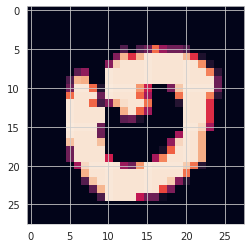

In [6]:
print("original image")
imagePlot(dfAll, 404)

after shifting image


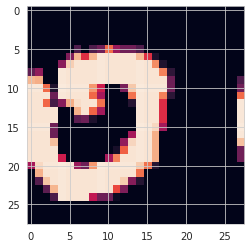

In [7]:
print("after shifting image")
imagePlot(df_shifted, 404)

<class 'numpy.ndarray'> (28, 28)
<class 'numpy.ndarray'> (28, 28)


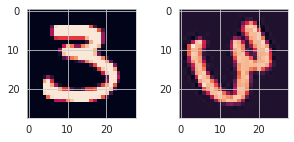

In [13]:
# image rotaion
from scipy import ndimage, misc
fig = plt.figure(figsize=(5,2))
ax1, ax2 = fig.subplots(1,2)
row = dfAll.iloc[3333]
img = row[:784]
img = img.values.reshape(28,28)
img_rotated = ndimage.rotate(img, -60, reshape=False)
print(type(img), img.shape)
print(type(img_rotated), img_rotated.shape)
ax1.imshow(img)
ax2.imshow(img_rotated)
plt.show()

In [58]:
def pd_rotate(df):
    randAngle = random.randint(-180, 180)
    array_rotated = np.zeros(df.shape)
    array_rotated[:, -1] = df.iloc[:, -1]
    for i in range(len(df)):
        row = df.iloc[i]
        img = row[:784]
        img = img.values.reshape(28,28)
        img = ndimage.rotate(img, randAngle, reshape=False)
        img = img.reshape(-1, 784)
        array_rotated[i, :784] = img
    df_rotated = pd.DataFrame(array_rotated)
    return df_rotated

In [61]:
df_rotated = pd_rotate(dfAll)
df_rotated['digit'] = dfAll['digit'].values

In [36]:
# funtion multiPerformance
# used to implement the multi-dimensional counter

# first of all, nested_defaultdict for confusion matrix
from collections import defaultdict
from functools import partial
from itertools import repeat
def nested_defaultdict(default_factory,depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth-1):
        result = partial(defaultdict, result)
    return result()

def multiPerformance(y, y_pred, y_score, debug=False):
    cm = nested_defaultdict(int, 2)
    classes = set()
    totalTrue = defaultdict(int)
    totalPred = defaultdict(int)
    for i in range(len(y_pred)):
        trueClass = y[i]
        classes.add(trueClass)
        predClass = y_pred[i]
        totalTrue[trueClass] += 1
        totalPred[predClass] += 1
        cm[trueClass][predClass] += 1
    if debug:
        for trueClass in classes:
            print("True: ", trueClass, end="")
            for predClass in classes:
                print("\t", cm[trueClass][predClass],end="")
            print()
        print()
    accMicro = 0.0
    accMacro = 0.0
    for cl in classes:
        accMicro += cm[cl][cl]
        accMacro += cm[cl][cl]/totalTrue[cl]
    accMicro /= len(y)
    accMacro = accMacro/len(classes)
    
    TP = TF = FP = FN = 0.0
    precisionTotal = recallTotal = 0.0
    for i in range(len(classes)):
        TP_1 = 0.0
        TN_1 = 0.0
        FP_1 = 0.0
        FN_1 = 0.0
        TP_1 += cm[i][i]
        for j in range(len(classes)):
            if j != i:
                TN_1 += cm[j][j]
                FP_1 += cm[i][j]
                FN_1 += cm[j][i]
        precision_1 = TP_1/(TP_1 + FN_1)
        recall_1 = TP_1/(TP_1 + FP_1)
        precisionTotal += precision_1
        recallTotal += recall_1
    
    precisionMacro = precisionTotal/len(classes)
    recallMacro = recallTotal/len(classes)
    results = {"cm":cm,
               "accuracyMicro":accMicro,
               "accuracyMacro":accMacro, 
               "precisionMacro": precisionMacro, 
               "recallMacro": recallMacro}
    return results

In [45]:
def runFitter(estimator, X_train, y_train, X_test, y_test, debug=False):
    estimator.fit(X_train, y_train)
    y_train_pred = estimator.predict(X_train)
    y_train_score = estimator.decision_function(X_train)
    y_test_pred = estimator.predict(X_test)
    y_test_score = estimator.decision_function(X_test)
    results_test = multiPerformance(y_test, y_test_pred, y_test_score)
    results_train = multiPerformance(y_train, y_train_pred, y_train_score)
    results = {
        'cf_test':results_test['cm'],
        'cf_train':results_train['cm'],
        'accuracyMicro_test':results_test['accuracyMicro'],
        'accuracyMacro_test':results_test['accuracyMacro'],
        'accuracyMicro_train':results_train['accuracyMicro'],
        'accuracyMacro_train':results_train['accuracyMacro'],
        'precisionMacro_train': results_train['precisionMacro'],
        'precisionMacro_test': results_test['precisionMacro'],
        'recallMacro_train': results_train['recallMacro'],
        'recallMacro_test': results_test['recallMacro'],
}

    return results

In [62]:
# shuffle data
from sklearn.utils import shuffle
dfAllShuffle = shuffle(dfAll, random_state=42)
## using original data
#X = dfAllShuffle.to_numpy()[:, :784]
#X = X.reshape(-1, 784)
#y = dfAllShuffle['digit'].values

## using shifted data
#df_s_shuffle = shuffle(df_shifted, random_state=404)
#X = df_s_shuffle.to_numpy()[:, :784]
#y = df_s_shuffle['digit'].values

# using rotated data
df_r_shuffle = shuffle(df_rotated, random_state=404)
X = df_r_shuffle.to_numpy()[:, :784]
y = df_r_shuffle['digit'].values

In [63]:
# setup kfolds
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
kfolds = 5
skf = StratifiedKFold(n_splits=kfolds)

In [64]:
# from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

estimator = LinearSVC(random_state=404, dual=False, max_iter=500, tol=0.01)
#estimator = SGDClassifier(random_state=404, max_iter=500, tol=0.01)
avg_accuracyMicro_test = 0.0
avg_accuracyMicro_train = 0.0
avg_accuracyMacro_test = 0.0
avg_accuracyMacro_train = 0.0
avg_precisionMacro_test = 0.0
avg_precisionMacro_train = 0.0
avg_recallMacro_test = 0.0
avg_recallMacro_train = 0.0
numSplits = 0.0

# Now loop
lastCF_train = None
lastCF_test = None
for train_index, test_index in skf.split(X, y):
        print("Training")
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
  
        # Now fit to training set
        results = runFitter(estimator,X_train,y_train,X_test,y_test)
        avg_accuracyMicro_test += results['accuracyMicro_test']
        avg_accuracyMicro_train += results['accuracyMicro_train']
        avg_accuracyMacro_test += results['accuracyMacro_test']
        avg_accuracyMacro_train += results['accuracyMacro_train']
        avg_precisionMacro_test += results['precisionMacro_test']
        avg_precisionMacro_train += results['precisionMacro_train']
        avg_recallMacro_test += results['recallMacro_test']
        avg_recallMacro_train += results['recallMacro_train']
        lastCF_train = results['cf_train']
        lastCF_test = results['cf_test']
        numSplits += 1.0
        print("   Split ",numSplits,"; accuracyMicro test/train",results['accuracyMicro_test'],results['accuracyMicro_train'],"; accuracyMacro test/train",results['accuracyMacro_test'],results['accuracyMacro_train'])

avg_accuracyMicro_test /= numSplits
avg_accuracyMicro_train /= numSplits
avg_accuracyMacro_test /= numSplits
avg_accuracyMacro_train /= numSplits
avg_precisionMacro_train /= numSplits
avg_recallMacro_train /= numSplits
avg_precisionMacro_test /= numSplits
avg_recallMacro_test /= numSplits


print("average accuracyMicro test:  ",avg_accuracyMicro_test)
print("average accuracyMicro train: ",avg_accuracyMicro_train)
print("average accuracyMacro test:  ",avg_accuracyMacro_test)
print("average accuracyMacro train: ",avg_accuracyMacro_train)
print("average precisonMacro test: ", avg_precisionMacro_test)
print("average precisonMacro train: ", avg_precisionMacro_train)
print("average recallMacro test: ", avg_recallMacro_test)
print("average recallMacro train: ", avg_recallMacro_train)
print("Test confusion matrix")
for trueClass in range(11):
    print("True: ",trueClass,end="")
    for predClass in range(11):
        print("\t",lastCF_test[trueClass][predClass],end="")
    print()
print()
print("Train confusion matrix")
for trueClass in range(11):
    print("True: ",trueClass,end="")
    for predClass in range(11):
        print("\t",lastCF_train[trueClass][predClass],end="")
    print()
print()


Training
   Split  1.0 ; accuracyMicro test/train 0.8875 0.966 ; accuracyMacro test/train 0.8875 0.9659999999999999
Training
   Split  2.0 ; accuracyMicro test/train 0.8835 0.963125 ; accuracyMacro test/train 0.8835000000000001 0.9631250000000001
Training
   Split  3.0 ; accuracyMicro test/train 0.875 0.96825 ; accuracyMacro test/train 0.8750000000000002 0.9682499999999999
Training
   Split  4.0 ; accuracyMicro test/train 0.8795 0.964625 ; accuracyMacro test/train 0.8795 0.9646250000000001
Training
   Split  5.0 ; accuracyMicro test/train 0.8895 0.965625 ; accuracyMacro test/train 0.8895 0.9656250000000002
average accuracyMicro test:   0.883
average accuracyMicro train:  0.9655250000000001
average accuracyMacro test:   0.883
average accuracyMacro train:  0.9655250000000001
average precisonMacro test:  0.8828523402912438
average precisonMacro train:  0.9655459924272958
average recallMacro test:  0.883
average recallMacro train:  0.9655250000000001
Test confusion matrix
True:  0	 192	 0	

### run fitter and check performance for **shifted** data set

In [49]:
df_s_shuffle = shuffle(df_shifted, random_state=404)
X_s = df_s_shuffle.to_numpy()[:, :784]
y_s = df_s_shuffle['digit'].values

In [ ]:
estimator_s = LinearSVC(random_state=404, 
                        dual=False, 
                        max_iter=500, 
                        tol=0.01)
results_s = runFitter(estimator_s, X)